# EDA do dataset do VLabs Challenge

Esse notebook compreende a análise exploratória dos dados do desafio VLabs, promovido pela Viságio. O desafio consiste em um modelo preditivo que realiza uma tarefa de regressão para responder à seguinte pergunta:

*Qual a previsão de LTV (Lifetime Value) do cliente para os próximos 90 dias?*

# Importar pacotes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [2]:
#aaaaand a nice setup for graphics cause why not
#blue and salmon
sns.set(font = 'Serif', style = 'white', rc = {'axes.facecolor':'#f1f1f1', 'figure.facecolor':'#f1f1f1'})

# Carregar os dados

In [3]:
df = pd.read_csv('C:/Users/ticom/VLabs/Data/sales_20_21_train.csv', header=0,)
df_sub = pd.read_csv('C:/Users/ticom/VLabs/Data/sample_submission.csv',header=0)

## Pré-visualizar

In [4]:
print(f""" Dimensões do dataset de treino: 
                             Linhas: {df.shape[0]}       
                             Colunas: {df.shape[1]}
Primeiras linhas:""")
df.head()

 Dimensões do dataset de treino: 
                             Linhas: 1630612       
                             Colunas: 7
Primeiras linhas:


,ID_VENDA,DT_VENDA,LOJA,QTD_SKU,VALOR,ID_CLIENTE,CANAL
0,1176550,2020-01-02,37,1,9.50,337763,FIS
1,11683461,2020-01-02,15,1,6.64,195687,FIS
2,3326484,2020-01-02,29,5,446.87,56059,FIS
3,7317475,2020-01-02,18,1,6.13,297533,FIS
4,4366938,2020-01-02,23,1,13.17,181284,FIS


In [5]:
print(f""" Dimensões do dataset de submissão: 
                             Linhas: {df_sub.shape[0]}       
                             Colunas: {df_sub.shape[1]}
Primeiras linhas:""")
df_sub.head()

 Dimensões do dataset de submissão: 
                             Linhas: 126616       
                             Colunas: 2
Primeiras linhas:


,ID_CLIENTE,VALOR
0,4,0.0
1,9,0.0
2,12,0.0
3,15,0.0
4,19,0.0


# Entendendo as colunas

O dataset compreende uma lista de vendas feitas em diferentes varejos a diferentes clientes.

Descrição dos campos:

- ID_VENDA - Id único para cada registro (categórico)
- DT_VENDA - Data da venda (tempo)
- LOJA - Id único da loja em que a venda foi realizada (categórico)
- QTD_SKU - Quantidade de produtos vendidos (numérico)
- VALOR - Valor total da venda (numérico)
- ID_CLIENTE - Id único do cliente (categorico)
- CANAL - Canal de venda (FIS - Físico, ECM - E-commerce, TELEVENDAS - Telefone, WHATSAPP - WhatsApp, IFOOD - iFood) (categórico)


A partir desses dados, precisamos prever o LTV para cada cliente após 90 dias.

In [6]:
primary_key = ['ID_VENDA']
cat_vars = ['LOJA','ID_CLIENTE','CANAL']
num_vars = ['QTD_SKU']
time_vars = ['DT_VENDA']
target = ['VALOR']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630612 entries, 0 to 1630611
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   ID_VENDA    1630612 non-null  int64  
 1   DT_VENDA    1630612 non-null  object 
 2   LOJA        1630612 non-null  int64  
 3   QTD_SKU     1630612 non-null  int64  
 4   VALOR       1630612 non-null  float64
 5   ID_CLIENTE  1630612 non-null  int64  
 6   CANAL       1630612 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 87.1+ MB


In [108]:
for var in df.columns:
    print(f'Unique values in {var}: {df[var].nunique()}')

Unique values in ID_VENDA: 1630612
Unique values in DT_VENDA: 406
Unique values in LOJA: 52
Unique values in QTD_SKU: 83
Unique values in VALOR: 38459
Unique values in ID_CLIENTE: 210269
Unique values in CANAL: 5


# Pré-processamento

Nesta seção, trataremos os dados e faremos uma engenharia de features inicial para termos mais dados (metadados) para explorar e tentar entender as relações e comportamentos.

## Valores Faltantes

In [8]:
df.isna().sum()

ID_VENDA      0
DT_VENDA      0
LOJA          0
QTD_SKU       0
VALOR         0
ID_CLIENTE    0
CANAL         0
dtype: int64

Nenhum valor faltante.

## Dtypes

Vamos garantir que as colunas estão nos formatos certos para facilitar a manipulação, principalmente da variável de tempo `DT_VENDA`:

In [9]:
def fix_dtype_func(x):
    """ Acerta os tipos das colunas """
    x=x.copy()
    try:
        for var in cat_vars:
            x[var] = x[var].astype('O')
        for var in num_vars:
            x[var] = x[var].astype('int')
        for var in time_vars:
            x[var] = pd.to_datetime(x[var])
    except Exception as err:
        print('Erro em fix_dtype_func')
        print(err)
    return x

# Viabiliza usar a função como um transformador do scikit-learn
get_fix_dtype = FunctionTransformer(fix_dtype_func)

In [10]:
# cria um dataset aplicando a transformação
df_type = get_fix_dtype.transform(df)
df_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630612 entries, 0 to 1630611
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   ID_VENDA    1630612 non-null  int64         
 1   DT_VENDA    1630612 non-null  datetime64[ns]
 2   LOJA        1630612 non-null  object        
 3   QTD_SKU     1630612 non-null  int32         
 4   VALOR       1630612 non-null  float64       
 5   ID_CLIENTE  1630612 non-null  object        
 6   CANAL       1630612 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 80.9+ MB


## Feature de tempo

Para facilitar a manipulação, vamos abrir a variável `DT_VENDAS` em `ANO`, `MES` e `DIA`:

In [102]:
def time_features_func(x):
    """ Cria colunas com ano, mês e dia das vendas"""
    # cria cópia para não alterar o df original por acidente
    x=x.copy()
    try:
        x['ANO'] = x['DT_VENDA'].dt.year
        x['MES'] = x['DT_VENDA'].dt.month
        x['DIA'] = x['DT_VENDA'].dt.day
        x = x.drop(['DT_VENDA'],axis=1).copy()
    except Exception as err:
        print('Erro em fix_dtype_func')
        print(err)
    return x

# Viabiliza usar a função como um transformador do scikit-learn
get_time_features = FunctionTransformer(time_features_func)

In [103]:
# cria um dataset aplicando a transformação
df_time = get_time_features.transform(df_type)
df_time.head()

,ID_VENDA,LOJA,QTD_SKU,VALOR,ID_CLIENTE,CANAL,ANO,MES,DIA
0,1176550,37,1,9.50,337763,FIS,2020,1,2
1,11683461,15,1,6.64,195687,FIS,2020,1,2
2,3326484,29,5,446.87,56059,FIS,2020,1,2
3,7317475,18,1,6.13,297533,FIS,2020,1,2
4,4366938,23,1,13.17,181284,FIS,2020,1,2


In [104]:
df_20 = df_time[df_time['ANO']==2020]
df_21 = df_time[df_time['ANO']==2021]

In [105]:
df_21

,ID_VENDA,LOJA,QTD_SKU,VALOR,ID_CLIENTE,CANAL,ANO,MES,DIA
1395907,11387535,18,12,289.45,149310,FIS,2021,1,2
1395908,2942502,31,2,49.57,118591,FIS,2021,1,2
1395909,8563927,8,3,53.69,327205,FIS,2021,1,2
1395910,1864130,39,2,6.93,51178,FIS,2021,1,2
1395911,8668443,16,4,31.94,141369,FIS,2021,1,2
...,...,...,...,...,...,...,...,...,...
1630607,2479951,38,3,94.69,23473,FIS,2021,2,24
1630608,10228861,2,5,141.58,259864,FIS,2021,2,24
1630609,11911135,13,12,191.66,299242,FIS,2021,2,24
1630610,11202897,18,3,71.57,353139,IFOOD,2021,2,24


# Exploração

Perguntas:
- valor médio por mês
- valor
- valor médio por cliente - tentar discretizar - ver quartis
- 

## Valor médio por mês

In [83]:
media_mes_20 = df_time.groupby(['ANO','MES'])['VALOR'].mean()[:12]
print(media_mes_20)
media_mes_21 = df_time.groupby(['ANO','MES'])['VALOR'].mean()[12:14]
print(media_mes_21)
#std_mes = df_time.groupby(['MES'])['VALOR'].std()
#print(std_mes)

ANO   MES
2020  1       49.704415
      2       51.873888
      3       61.727801
      4       97.819020
      5      107.540680
      6      101.716184
      7       89.874623
      8       88.526555
      9       78.655404
      10      76.976812
      11      80.877278
      12     108.262040
Name: VALOR, dtype: float64
ANO   MES
2021  1      73.431423
      2      74.172888
Name: VALOR, dtype: float64


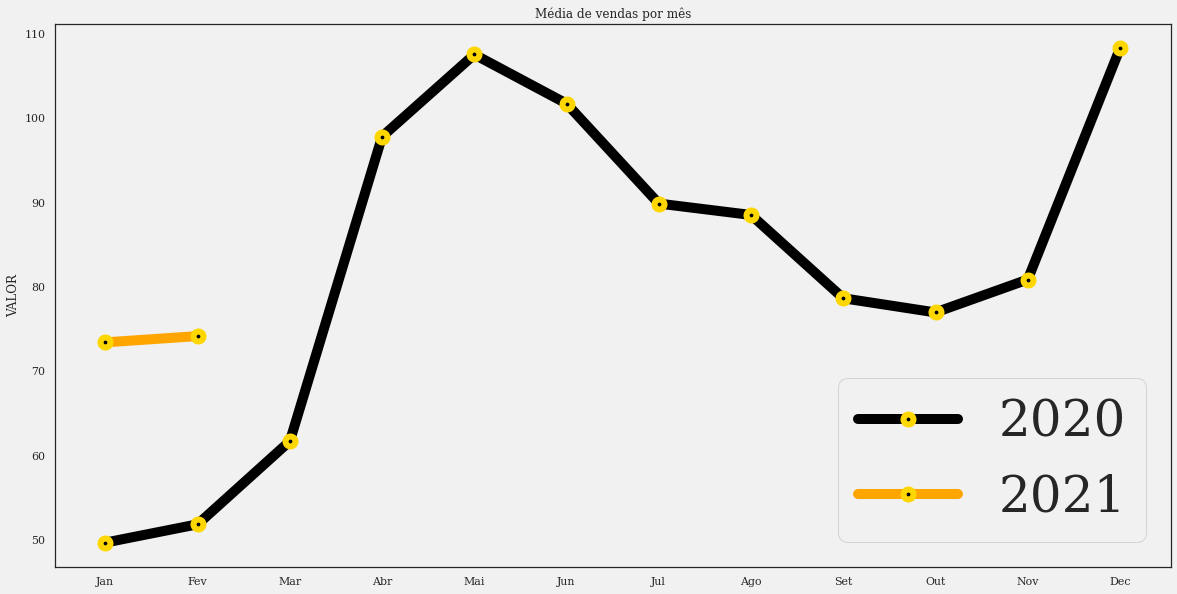

In [84]:
fig, ax = plt.subplots(1,figsize=(20,10))
list_mes=['Jan','Fev','Mar', 'Abr','Mai', 'Jun', 'Jul','Ago','Set','Out','Nov','Dec']
sns.lineplot(y=media_mes_20,x=list_mes,ax=ax,marker='o', linewidth=10, mec='gold',mfc='black',mew=10,color='black')
plt.title('Média de vendas por mês')
sns.lineplot(y=media_mes_21,x=['Jan','Fev'],ax=ax,marker='o', linewidth=10, mec='gold',mfc='black',mew=10,color='orange')
plt.legend(['2020','2021'], loc='best',fontsize=50)
plt.show()

## Ticket médio de cada cliente

O ticket médio de cada cliente pode ajudar a prever quanto este gastará nos próximos 90 dias. Vamos criar uma coluna com essa informação agrupada por diferentes critérios.

In [101]:
pd.DataFrame(df_20.groupby(['ID_CLIENTE','MES'])['VALOR'].mean())

VALOR
ID_CLIENTE MES         
0          9    266.940
           12   369.350
2          1     60.540
           4    200.680
           6    104.690
...                 ...
384418     9     10.390
           10    16.232
           11    24.390
384420     11   131.670
           12   225.930

[799422 rows x 1 columns]

In [ ]:
# ticked médio de todos os clientes
print(f'valor médio de df.groupby(['ID_CLIENTE'])['VALOR'].mean().mean()